In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

### 1. Processing data

#### Incidents data

Aggregate the incidents data into grids with side lengths of 500m and calculate the centroid of each grid. Calculate the response time of each event. The definition of response time here is reaction seconds plus driving seconds according to the requirements.

In [ ]:
incidents = pd.read_csv('Data/WMFS_datasets/wmfs_incidents.csv')
# Only pay attention to incidents of type 'FIRE' and 'FALSE_ALARM'
incidents = incidents[incidents['incident_classification_level1'].isin(['FIRE', 'FALSE_ALARM'])]

### If only focus on the data in 2018 and 2019, uncomment these lines
# incidents['call_time'] = pd.to_datetime(incidents['call_time'])
# incidents = incidents[(incidents['call_time'].dt.year == 2018) | (incidents['call_time'].dt.year == 2019)]

incidents = incidents.reset_index(drop=True)

In [ ]:
### Aggregate the data into grids
# Define the grid size
grid_size = 500

# Calculate the bound
xmin = incidents['EASTINGS'].min() // grid_size * grid_size # // means quotient rounding
xmax = incidents['EASTINGS'].max() // grid_size * grid_size + grid_size # rounding down so another grid needs to be added
ymin = incidents['NORTHINGS'].min() // grid_size * grid_size
ymax = incidents['NORTHINGS'].max() // grid_size * grid_size + grid_size
# Caculate the grid index
incidents['grid_x'] = ((incidents['EASTINGS'] - xmin) // grid_size).astype(int)
incidents['grid_y'] = ((incidents['NORTHINGS'] - ymin) // grid_size).astype(int)

# Add a grid_id to each incident and fire station
incidents['grid_id'] = incidents['grid_x'].astype(str) + "_" + incidents['grid_y'].astype(str)

In [ ]:
### Caculate the centroid of each grid
incidents['centroid_x'] = xmin + (incidents['grid_x'] + 0.5) * grid_size
incidents['centroid_y'] = ymin + (incidents['grid_y'] + 0.5) * grid_size

# Extract the centroid coordinates into a new dataframe to facilitate merging later
grid_centroids = incidents[['grid_id', 'centroid_x', 'centroid_y']].drop_duplicates().reset_index(drop=True)
grid_centroids

,grid_id,centroid_x,centroid_y
0,12_29,392250.0,286750.0
1,39_11,405750.0,277750.0
2,48_33,410250.0,288750.0
3,21_54,396750.0,299250.0
4,49_36,410750.0,290250.0
...,...,...,...
3729,79_22,425750.0,283250.0
3730,68_8,420250.0,276250.0
3731,2_32,387250.0,288250.0
3732,69_9,420750.0,276750.0


In [ ]:
# Define 'total response time'
incidents['total_response_time'] = incidents['reaction_seconds'] + incidents['driving_seconds']
incidents

,call_time,incident_classification_label,incident_profile_label,incident_classification_level1,prl_count,brv_count,EASTINGS,NORTHINGS,call_seconds,reaction_seconds,driving_seconds,grid_x,grid_y,grid_id,centroid_x,centroid_y,total_response_time
0,2009/1/1 0:00,False alarm raised with good intent,False Alarms,FALSE_ALARM,2,0,392062.1020,286844.9690,86,160,250,12,29,12_29,392250.0,286750.0,410
1,2009/1/1 0:10,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,405643.1494,277939.9802,85,65,239,39,11,39_11,405750.0,277750.0,304
2,2009/1/1 0:11,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410260.2444,288819.1894,62,106,115,48,33,48_33,410250.0,288750.0,221
3,2009/1/1 0:53,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,396779.2503,299030.1061,72,109,96,21,54,21_54,396750.0,299250.0,205
4,2009/1/1 0:52,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410667.9614,290492.4786,68,109,204,49,36,49_36,410750.0,290250.0,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292692,2023/12/31 22:59,False Alarms (Equipment),Low Risk,FALSE_ALARM,2,0,398666.6867,283225.4570,88,82,281,25,22,25_22,398750.0,283250.0,363
292693,2023/12/31 23:11,False alarm raised with good intent,False Alarms,FALSE_ALARM,1,1,433136.8678,277909.0307,134,94,98,94,11,94_11,433250.0,277750.0,192
292694,2023/12/31 23:32,Accidental secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,0,1,401134.3304,277356.6820,136,152,227,30,10,30_10,401250.0,277250.0,379
292695,2023/12/31 23:49,False Alarms (Equipment),Low Risk,FALSE_ALARM,0,1,406221.0587,290654.1816,253,66,297,40,37,40_37,406250.0,290750.0,363


#### Station data

In [5]:
stations = pd.read_csv('Data/WMFS_datasets/station_locations.csv')

In [6]:
# stations = stations[stations['Closed (Y/N)'] == 'N']
# stations

,Station name,Easting,Northing,PRL_Count,BRV_Count,Closed (Y/N),Opened,Closed
0,Aldridge,405203,302818,1,0,N,Before study period,NaN
1,Aston,407316,289711,1,1,N,Before study period,NaN
2,Bickenhill,419627,284038,1,0,N,Before study period,NaN
3,Billesley,409029,281369,1,1,N,Before study period,NaN
4,Bilston,394543,296040,1,0,N,Before study period,NaN
5,Binley,436876,278691,1,1,N,Before study period,NaN
6,Bloxwich,399846,301797,1,0,N,Before study period,NaN
7,Bournbrook,405167,283287,1,0,N,Before study period,NaN
8,Brierley Hill,391862,287775,1,1,N,Before study period,NaN
9,Canley,430542,277280,1,0,N,Before study period,NaN


#### Metric selection of fire response time
**median and 90 percentile**

In [11]:
metrics = incidents.groupby('grid_id')['total_response_time'].agg(
    median='median',
    percentile_90=lambda x: np.percentile(x, 90)
)

metrics

,median,percentile_90
grid_id,,
0_51,399.0,399.0
0_52,444.0,622.6
0_53,437.5,520.9
100_10,391.0,575.0
100_11,294.0,526.8
...,...,...
9_59,419.0,657.0
9_60,387.5,531.7
9_61,405.0,525.8


### 2. Feature data manipulation

Create a grid geodataframe containing the geographical information of each grid. And load shapefiles for OAs and LSOAs.

In [12]:
### Create a geodataframe for grid
from shapely.geometry import box

cols = list(range(int(xmin), int(xmax), grid_size))
rows = list(range(int(ymin), int(ymax), grid_size))
grid_polygon = []
grid_id_list = []
for i, x in enumerate(cols):
    for j, y in enumerate(rows):
        grid_polygon.append(box(x, y, x + grid_size, y + grid_size))
        grid_id_list.append(f"{i}_{j}")
        
grid_gdf = gpd.GeoDataFrame({'grid_id': grid_id_list, 'geometry': grid_polygon})
grid_gdf = grid_gdf[grid_gdf['grid_id'].isin(incidents['grid_id'])].reset_index(drop = True)
grid_gdf

,grid_id,geometry
0,0_51,"POLYGON ((386500.000 297500.000, 386500.000 29..."
1,0_52,"POLYGON ((386500.000 298000.000, 386500.000 29..."
2,0_53,"POLYGON ((386500.000 298500.000, 386500.000 29..."
3,1_51,"POLYGON ((387000.000 297500.000, 387000.000 29..."
4,1_52,"POLYGON ((387000.000 298000.000, 387000.000 29..."
...,...,...
3729,105_18,"POLYGON ((439000.000 281000.000, 439000.000 28..."
3730,105_19,"POLYGON ((439000.000 281500.000, 439000.000 28..."
3731,105_20,"POLYGON ((439000.000 282000.000, 439000.000 28..."
3732,106_18,"POLYGON ((439500.000 281000.000, 439500.000 28..."


In [13]:
grid_gdf = grid_gdf.set_crs(epsg=27700)

In [14]:
### Save the grid geodataframe
grid_gdf.to_file('Data/grid/grid_geometry.shp')

In [15]:
### Load the boundary of OAs and LSOAs
OAs = gpd.read_file('Data/OAs_boundary/infuse_oa_lyr_2011.shp')
OAs = OAs[['geo_code', 'geometry']]

LSOAs = gpd.read_file('Data/LSOAs_boundary/infuse_lsoa_lyr_2011.shp')
LSOAs = LSOAs[['geo_code', 'geometry']]
LSOAs

,geo_code,geometry
0,E01003513,"POLYGON ((541893.189 181249.621, 541900.568 18..."
1,E01031647,"POLYGON ((518376.682 132574.695, 518375.785 13..."
2,E01022006,"POLYGON ((623754.716 231042.037, 623759.750 23..."
3,E01001159,"POLYGON ((532233.977 170474.976, 532229.824 17..."
4,E01008088,"POLYGON ((433539.233 392096.845, 433539.125 39..."
...,...,...
42614,E01029200,"POLYGON ((341784.812 127223.499, 341826.628 12..."
42615,E01003084,"POLYGON ((531528.786 171783.590, 531526.879 17..."
42616,E01020517,"POLYGON ((343718.406 91175.102, 343702.812 911..."
42617,E01004020,"POLYGON ((534979.720 175304.033, 534980.950 17..."


#### Point of interests

In [16]:
poi = pd.read_csv('Data/poi/poi.csv', delimiter='|', dtype={'pointx_class': str})
poi

,ref_no,name,pointx_class,feature_easting,feature_northing,pos_accuracy,uprn,topo_toid,topo_toid_version,usrn,...,geographic_county,postcode,admin_boundary,telephone_number,url,brand,qualifier_type,qualifier_data,provenance,supply_date
0,76327491,Ford,10540734,409945.0,282101.0,2,NaN,Not Assigned,0,2703266,...,West Midlands,B28,Birmingham District,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2023-12-01
1,78437564,Works,07410542,402393.0,288735.0,2,NaN,Not Assigned,0,33608460,...,West Midlands,B66,Sandwell District,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2023-12-01
2,78437565,Works,07410542,405887.0,287715.0,2,NaN,Not Assigned,0,2702457,...,West Midlands,B18,Birmingham District,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2023-12-01
3,78438083,Works,07410542,403842.0,288198.0,2,NaN,Not Assigned,0,33623420,...,West Midlands,B66,Sandwell District,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2023-12-01
4,78438084,Works,07410542,403734.0,288066.0,2,NaN,Not Assigned,0,33600040,...,West Midlands,B66,Sandwell District,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2023-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136342,145881644,Alderman Tye Scout Headquarters,06350452,389075.0,283881.0,1,NaN,osgb1000002075165269,3,11403328,...,West Midlands,DY8 3RJ,Dudley District,NaN,www.scouts.org.uk,The Scout Association,NaN,NaN,Ordnance Survey,2023-12-01
136343,145881772,Family Community Centre,06340456,415304.6,307077.2,1,NaN,osgb1000025374668,11,23401631,...,Staffordshire,WS14 9TJ,Lichfield District,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2023-12-01
136344,145881663,Neil Dougherty Community Centre,06340456,393393.0,302135.0,1,1.000712e+10,osgb1000024817313,6,44832350,...,West Midlands,WV10 8SA,City of Wolverhampton District,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2023-12-01
136345,145881918,Great Barr Methodist Church Hall,06340456,404597.0,294411.0,1,3.217615e+07,osgb1000020216141,5,33646700,...,West Midlands,B43 6PD,Sandwell District,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2023-12-01


In [17]:
poi_classification = pd.read_excel('Data/poi/classification.xlsx', dtype=str)
poi_classification

,No_group,Group,No_Category,Category
0,01,"Accommodation, eating and drinking",01,Accomodation
1,01,"Accommodation, eating and drinking",02,Eating and drinking
2,02,Commercial services,03,Construction services
3,02,Commercial services,04,Consultancies
4,02,Commercial services,05,Employment and career agencies
5,02,Commercial services,06,Engineering services
6,02,Commercial services,07,Contract services
7,02,Commercial services,08,"IT, advertising, marketing and media services"
8,02,Commercial services,09,Legal and financial
9,02,Commercial services,10,"Personal, consumer and other services"


In [18]:
poi = gpd.GeoDataFrame(poi, geometry=gpd.points_from_xy(poi['feature_easting'], poi['feature_northing']))

poi = gpd.sjoin(poi, grid_gdf, how = 'right', op='within')
poi = poi[['grid_id', 'pointx_class']]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_64223/3543890153.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:27700

  poi = gpd.sjoin(poi, grid_gdf, how = 'right', op='within')


In [19]:
# Get group and category information of poi from pointx_class
poi['group'] = poi['pointx_class'].str[:2]
poi['category'] = poi['pointx_class'].str[2:4]

# Drop duplicate rows
classification_group = poi_classification[['No_group', 'Group']].drop_duplicates()
classification_category = poi_classification[['No_Category', 'Category']].drop_duplicates()

# Merge group information
poi = poi.merge(classification_group, left_on='group', right_on='No_group', how='left')

# Merge category information
poi = poi.merge(classification_category, left_on='category', right_on='No_Category', how='left')


In [20]:
poi = poi[['grid_id', 'Group', 'Category']].fillna(0)
poi

,grid_id,Group,Category
0,0_51,0,0
1,0_52,Education and health,Recreational and vocational education
2,0_52,Public infrastructure,Infrastructure and facilities
3,0_52,Sport and entertainment,Sport and entertainment support services
4,0_53,Education and health,"Primary, secondary and tertiary education"
...,...,...,...
111683,106_19,Retail,"Food, drink and multi item retail"
111684,106_19,Public infrastructure,Infrastructure and facilities
111685,106_19,Public infrastructure,Infrastructure and facilities
111686,106_19,Transport,Road and rail


In [21]:
poi_group = poi.groupby(['grid_id', 'Group']).size().unstack(fill_value=0).reset_index().drop(columns = 0)
poi_group.columns.name = None
poi_group

,grid_id,"Accommodation, eating and drinking",Attractions,Commercial services,Education and health,Manufacturing and production,Public infrastructure,Retail,Sport and entertainment,Transport
0,0_51,0,0,0,0,0,0,0,0,0
1,0_52,0,0,0,1,0,1,0,1,0
2,0_53,0,1,0,1,1,1,0,0,7
3,100_10,0,2,1,2,0,4,0,2,2
4,100_11,0,1,3,0,0,1,0,1,7
...,...,...,...,...,...,...,...,...,...,...
3729,9_59,0,0,2,1,1,1,1,0,0
3730,9_60,0,0,13,2,2,3,2,1,4
3731,9_61,0,1,1,1,0,5,0,1,1
3732,9_62,3,1,4,0,0,5,1,3,5


In [22]:
poi_category = poi.groupby(['grid_id', 'Category']).size().unstack(fill_value=0).reset_index().drop(columns = 0)
poi_category.columns.name = None
poi_category

,grid_id,Accomodation,Air,Animal welfare,Bodies of water,Botanical and zoological,Bus transport,Central and local government,Clothing and accessories,Construction services,...,Repair and servicing,Research and design,Road and rail,Sport and entertainment support services,Sports complex,Tourism,"Transport, storage and delivery","Venues, stage and screen",Walking,Water
0,0_51,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0_52,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0_53,0,0,0,0,0,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,100_10,0,0,0,0,0,0,0,0,0,...,0,0,2,0,1,0,0,1,0,0
4,100_11,0,0,0,0,0,4,0,0,1,...,0,0,2,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,9_59,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3730,9_60,0,0,0,0,0,4,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3731,9_61,0,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3732,9_62,0,0,0,0,0,4,0,0,1,...,0,0,1,0,3,0,0,0,0,0


#### Land use

See the dataset in 'Data/land_cover/result'.

In [ ]:
# land_use = gpd.read_file('Data/land_cover/land_verisk.gpkg')

In [ ]:
# land_use

In [ ]:
# land_use_f = gpd.overlay(grid_gdf, land_use, how='intersection')
# land_use_f['area'] = land_use_f['geometry'].area
# land_use_f['total_area'] = 500 * 500

# land_use_f['land_use_percentage'] = (land_use_f['area'] / land_use_f['total_area']) * 100

# land_use_f = land_use_f.groupby(['grid_id', 'landuse_text'])['land_use_percentage'].sum()
# land_use_f = land_use_f.unstack(fill_value=0).reset_index()
# land_use_f.columns.name = None

# land_use_f

#### Buildings

In [23]:
buildings = gpd.read_file('Data/buildings/buildings.gpkg')

In [24]:
buildings

,unique_property_number,unique_building_number,property_area,building_area,mapping_block_number,height,age,use,data_level,geometry
0,366523,37289440,44.0,44.0,GC0715,16.1,UNCLASSIFIED,AGRICULTURAL - UNCLASSIFIED,FHU,"POLYGON ((433497.170 273089.270, 433502.270 27..."
1,806987,35799377,60.8,60.8,FD1902,7.8,UNCLASSIFIED,RESIDENTIAL ONLY,FHU,"POLYGON ((390776.630 306615.500, 390774.740 30..."
2,1455770,37258348,151.6,151.6,GC0519,3.5,UNCLASSIFIED,RESIDENTIAL ONLY,FHU,"POLYGON ((424671.450 291340.880, 424681.560 29..."
3,1469169,35754295,52.7,52.7,FC1820,5.8,UNCLASSIFIED,GENERAL COMMERCIAL - MIXED USE,FHU,"POLYGON ((387518.970 297285.350, 387520.500 29..."
4,1532385,35575803,135.1,135.1,FC1815,9.4,UNCLASSIFIED,RESIDENTIAL ONLY,FHU,"POLYGON ((387868.000 274453.230, 387877.460 27..."
...,...,...,...,...,...,...,...,...,...,...
1363584,29937966,37304803,86.5,86.5,GC0815,8.7,UNCLASSIFIED,RESIDENTIAL ONLY,FHU,"POLYGON ((438576.030 274387.670, 438576.560 27..."
1363585,29938447,36921356,63.8,63.8,FC2015,8.7,UNCLASSIFIED,RESIDENTIAL ONLY,FHU,"POLYGON ((397208.966 274289.608, 397213.535 27..."
1363586,29944662,37287193,13.3,13.3,GC0715,3.0,UNCLASSIFIED,RESIDENTIAL ONLY,FHU,"POLYGON ((430076.589 272643.752, 430076.902 27..."
1363587,37674004,37254223,212.9,212.9,GC0518,0.0,UNCLASSIFIED,UNCLASSIFIED,F,"POLYGON ((420259.720 287622.090, 420254.530 28..."


In [25]:
buildings_df = buildings.drop(columns='geometry')

In [26]:
### Calculate the centroid of buildings
buildings['centroid'] = buildings.geometry.centroid
buildings = buildings.drop(columns = 'geometry')
buildings = buildings.set_geometry('centroid')

# find buildings are in which grid
buildings_f= gpd.sjoin(buildings, grid_gdf, how='right', op='within')
buildings_f['count'] = buildings_f['unique_property_number'].notna().astype(int)


# count the buildings
buildings_f = buildings_f.groupby('grid_id')['count'].sum().reset_index(name = 'building_count')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [27]:
buildings_f

,grid_id,building_count
0,0_51,2
1,0_52,87
2,0_53,49
3,100_10,27
4,100_11,294
...,...,...
3729,9_59,374
3730,9_60,589
3731,9_61,325
3732,9_62,283


In [28]:
output_file_path = 'Data/buildings/buildings_result.csv'
buildings_f.to_csv(output_file_path, index=False, encoding='utf-8')

#### Total rented

In [29]:
rent = pd.read_excel('Data/rent/rent.xlsx', sheet_name = '1c', skiprows = 2)
rent

,LSOA code,LSOA name,Owned: Owns outright,"Owned: Owns with a mortgage, loan or shared ownership",Social rented,Private rented or lives rent free
0,E01000001,City of London 001A,335,150,20,330
1,E01000002,City of London 001B,285,150,25,365
2,E01000003,City of London 001C,235,145,300,335
3,E01000005,City of London 001E,20,20,335,105
4,E01000006,Barking and Dagenham 016A,110,165,25,255
...,...,...,...,...,...,...
35667,W01002036,Vale of Glamorgan 005G,195,260,110,205
35668,W01002037,Vale of Glamorgan 005H,175,165,40,185
35669,W01002038,Vale of Glamorgan 014G,245,165,80,90
35670,W01002039,Vale of Glamorgan 014H,150,385,80,55


In [30]:
# Replace the extremely low value c with 5
rent = rent.replace('c', 5)
rent['total_rent'] = rent['Social rented'] + rent['Private rented or lives rent free']
rent = rent[['LSOA code', 'total_rent']]

In [31]:
rent_LSOA = pd.merge(rent, LSOAs, left_on='LSOA code', right_on='geo_code', how='left')
rent_LSOA = gpd.GeoDataFrame(rent_LSOA, geometry='geometry')
rent_LSOA = rent_LSOA.drop(columns = 'LSOA code')

rent_LSOA

,total_rent,geo_code,geometry
0,350,E01000001,"POLYGON ((532162.491 181867.763, 532175.289 18..."
1,390,E01000002,"POLYGON ((532341.000 181928.000, 532340.921 18..."
2,635,E01000003,"POLYGON ((532089.264 182076.985, 532087.688 18..."
3,440,E01000005,"POLYGON ((533378.863 181459.766, 533381.505 18..."
4,280,E01000006,"POLYGON ((544817.826 184346.261, 544815.791 18..."
...,...,...,...
35667,315,NaN,None
35668,225,NaN,None
35669,170,NaN,None
35670,135,NaN,None


In [32]:
# Calculate the intersection of LSOAs and the grid
rent_LSOA['total_area_LSOA'] = rent_LSOA['geometry'].area

rent_f = gpd.overlay(grid_gdf, rent_LSOA, how='intersection')
rent_f['intersection_area'] = rent_f['geometry'].area

rent_f['area_LSOA_ratio'] = rent_f['intersection_area'] / rent_f['total_area_LSOA']

rent_f['total_rent'] = rent_f['total_rent'] * rent_f['area_LSOA_ratio']

rent_f = rent_f.groupby('grid_id')['total_rent'].sum().reset_index()

rent_f

/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_64223/868501794.py:4: UserWarning: `keep_geom_type=True` in overlay resulted in 197 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  rent_f = gpd.overlay(grid_gdf, rent_LSOA, how='intersection')


,grid_id,total_rent
0,0_51,2.756538
1,0_52,5.180923
2,0_53,5.540563
3,100_10,170.721062
4,100_11,78.999124
...,...,...
3723,9_59,92.974819
3724,9_60,160.313891
3725,9_61,141.396878
3726,9_62,75.967424


In [33]:
rent_f = pd.merge(grid_gdf, rent_f, on='grid_id', how='left').fillna(0)
rent_f = rent_f[['grid_id', 'total_rent']]
rent_f

,grid_id,total_rent
0,0_51,2.756538
1,0_52,5.180923
2,0_53,5.540563
3,1_51,16.535700
4,1_52,15.666019
...,...,...
3729,105_18,63.808852
3730,105_19,26.061081
3731,105_20,13.628787
3732,106_18,15.116996


In [34]:
output_file_path = 'Data/rent/rent_result.csv'
rent_f.to_csv(output_file_path, index=False, encoding='utf-8')

#### Population (children below 14 and elderly above 65)

##### Mid 2020

In [35]:
# Load 2020 Census data based on OAs
population = pd.read_excel('Data/population/census_OA_2020.xlsx', sheet_name = 'Mid-2020 Persons', skiprows = 4)

In [36]:
population

,OA11CD,LSOA11CD,All Ages,0,1,2,3,4,5,6,...,81,82,83,84,85,86,87,88,89,90+
0,E00045110,E01008881,284,1,3,4,2,2,6,6,...,5,2,0,0,5,2,2,1,3,1
1,E00045113,E01008881,345,1,5,4,8,5,2,5,...,0,0,1,0,2,0,1,0,2,0
2,E00045116,E01008881,446,10,9,4,5,8,12,8,...,0,3,6,0,0,0,1,3,1,1
3,E00045118,E01008881,383,7,5,5,2,4,7,3,...,4,2,4,2,1,1,2,6,1,3
4,E00045123,E01008881,271,1,3,3,9,5,3,6,...,3,2,0,2,1,0,0,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17911,E00047486,E01033650,199,5,1,3,1,3,3,4,...,0,0,0,1,0,0,0,0,0,2
17912,E00047487,E01033650,335,3,7,4,11,7,5,7,...,1,0,0,0,1,0,0,0,0,1
17913,E00047488,E01033650,420,4,10,10,9,7,5,2,...,0,1,1,1,3,1,1,0,0,2
17914,E00047490,E01033650,406,5,6,6,8,5,6,5,...,0,1,0,2,0,0,0,0,1,4


In [37]:
pop_OA = pd.merge(population, OAs, left_on='OA11CD', right_on='geo_code', how='left')
pop_OA = gpd.GeoDataFrame(pop_OA, geometry='geometry')
pop_OA = pop_OA.drop(columns = 'geo_code')

pop_OA['below_14'] = pop_OA.loc[:, 0:14].sum(axis=1)
pop_OA['above_65'] = pop_OA.loc[:, 65:'90+'].sum(axis=1)
pop_OA = pop_OA[['OA11CD', 'below_14', 'above_65', 'geometry']]

pop_OA

,OA11CD,below_14,above_65,geometry
0,E00045110,64,60,"POLYGON ((412998.416 285885.253, 412997.187 28..."
1,E00045113,82,37,"POLYGON ((412464.756 285838.494, 412465.177 28..."
2,E00045116,143,39,"POLYGON ((412629.706 285637.495, 412628.534 28..."
3,E00045118,76,61,"POLYGON ((413040.412 285809.794, 413039.650 28..."
4,E00045123,59,46,"POLYGON ((413054.394 285481.082, 413057.772 28..."
...,...,...,...,...
17911,E00047486,49,20,"POLYGON ((409332.952 284907.683, 409333.017 28..."
17912,E00047487,100,18,"POLYGON ((409363.000 284830.000, 409375.970 28..."
17913,E00047488,116,43,"POLYGON ((409301.116 284995.045, 409301.000 28..."
17914,E00047490,113,34,"POLYGON ((409143.453 284810.389, 409147.000 28..."


In [38]:
# Calculate the intersection of OAs and the grid
pop_OA['total_area_OA'] = pop_OA['geometry'].area

pop_f = gpd.overlay(grid_gdf, pop_OA, how='intersection')
pop_f['intersection_area'] = pop_f['geometry'].area

pop_f['area_OA_ratio'] = pop_f['intersection_area'] / pop_f['total_area_OA']

pop_f['below_14'] = pop_f['below_14'] * pop_f['area_OA_ratio']
pop_f['above_65'] = pop_f['above_65'] * pop_f['area_OA_ratio']

pop_f = pop_f.groupby('grid_id').agg(
    below_14 = ('below_14', 'sum'),
    above_65 = ('above_65', 'sum')
    ).reset_index()

pop_f

/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_64223/1118792808.py:4: UserWarning: `keep_geom_type=True` in overlay resulted in 366 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  pop_f = gpd.overlay(grid_gdf, pop_OA, how='intersection')


,grid_id,below_14,above_65
0,0_51,4.295945,9.609793
1,0_52,13.806764,39.551589
2,0_53,19.354585,42.606956
3,100_10,162.762178,53.084068
4,100_11,268.149714,95.126309
...,...,...,...
3729,9_59,164.247755,131.024999
3730,9_60,268.994018,177.161715
3731,9_61,197.549486,108.006668
3732,9_62,168.993990,171.377539


In [39]:
output_file_path = 'Data/population/population_result.csv'
pop_f.to_csv(output_file_path, index=False, encoding='utf-8')

#### Index of multiple deprivation score (LSOAs)

##### 2019

In [40]:
IMD = pd.read_excel('Data/IMD/Iod_2019.xlsx', sheet_name = 'IoD2019 Scores')
IMD

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Score,Income Score (rate),Employment Score (rate),"Education, Skills and Training Score",Health Deprivation and Disability Score,Crime Score,Barriers to Housing and Services Score,Living Environment Score,Income Deprivation Affecting Children Index (IDACI) Score (rate),Income Deprivation Affecting Older People (IDAOPI) Score (rate),Children and Young People Sub-domain Score,Adult Skills Sub-domain Score,Geographical Barriers Sub-domain Score,Wider Barriers Sub-domain Score,Indoors Sub-domain Score,Outdoors Sub-domain Score
0,E01000001,City of London 001A,E09000001,City of London,6.208,0.007,0.010,0.024,-1.654,-2.012,29.472,31.873,0.006,0.012,-2.107,0.032,-0.430,3.587,0.006,1.503
1,E01000002,City of London 001B,E09000001,City of London,5.143,0.034,0.027,0.063,-1.115,-2.343,24.412,23.084,0.037,0.030,-1.907,0.034,-1.060,3.231,-0.410,1.196
2,E01000003,City of London 001C,E09000001,City of London,19.402,0.086,0.086,5.804,-0.102,-1.032,40.103,40.535,0.052,0.128,-0.292,0.142,-0.691,5.173,-0.054,2.207
3,E01000005,City of London 001E,E09000001,City of London,28.652,0.211,0.136,22.260,-0.121,-1.317,39.900,28.979,0.209,0.322,0.338,0.321,-1.167,5.361,-0.604,1.769
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,19.837,0.117,0.059,14.798,-0.359,-0.147,45.171,26.888,0.155,0.162,-0.366,0.325,-0.400,5.590,0.110,0.969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32839,E01033764,Liverpool 022E,E08000012,Liverpool,74.468,0.470,0.341,73.723,2.361,1.316,16.867,20.426,0.414,0.544,1.135,0.613,-0.402,0.969,-0.189,0.750
32840,E01033765,Liverpool 061D,E08000012,Liverpool,59.599,0.362,0.280,59.571,1.665,1.015,19.411,12.584,0.492,0.455,1.374,0.479,-0.098,0.874,-0.554,0.283
32841,E01033766,Liverpool 042G,E08000012,Liverpool,21.895,0.099,0.073,11.133,0.823,0.054,4.477,58.942,0.097,0.207,0.138,0.178,-1.459,-1.360,1.513,0.629
32842,E01033767,Liverpool 050J,E08000012,Liverpool,66.704,0.396,0.291,64.836,1.828,0.314,11.968,57.424,0.520,0.465,1.651,0.465,-1.437,0.745,1.524,0.417


In [41]:
IMD_LSOA = pd.merge(IMD, LSOAs, left_on='LSOA code (2011)', right_on='geo_code', how='left')
IMD_LSOA = gpd.GeoDataFrame(IMD_LSOA, geometry='geometry')
IMD_LSOA = IMD_LSOA[['geo_code', 'Index of Multiple Deprivation (IMD) Score', 'geometry']]

IMD_LSOA

,geo_code,Index of Multiple Deprivation (IMD) Score,geometry
0,E01000001,6.208,"POLYGON ((532162.491 181867.763, 532175.289 18..."
1,E01000002,5.143,"POLYGON ((532341.000 181928.000, 532340.921 18..."
2,E01000003,19.402,"POLYGON ((532089.264 182076.985, 532087.688 18..."
3,E01000005,28.652,"POLYGON ((533378.863 181459.766, 533381.505 18..."
4,E01000006,19.837,"POLYGON ((544817.826 184346.261, 544815.791 18..."
...,...,...,...
32839,E01033764,74.468,"POLYGON ((334793.921 392861.045, 334793.719 39..."
32840,E01033765,59.599,"POLYGON ((334781.217 388411.057, 334781.000 38..."
32841,E01033766,21.895,"POLYGON ((338678.222 388300.778, 338679.000 38..."
32842,E01033767,66.704,"POLYGON ((335690.155 387392.805, 335688.051 38..."


In [42]:
# Calculate the intersection of LSOAs and the grid
# Calculate the proportion of a grid
IMD_f = gpd.overlay(grid_gdf, IMD_LSOA, how='intersection')
IMD_f['intersection_area'] = IMD_f['geometry'].area
IMD_f['total_area'] = 500 * 500

IMD_f['intersection_grid_ratio'] = IMD_f['intersection_area'] / IMD_f['total_area']

IMD_f['IMD'] = IMD_f['Index of Multiple Deprivation (IMD) Score'] * IMD_f['intersection_grid_ratio']

IMD_f = IMD_f.groupby('grid_id')['IMD'].sum().reset_index()

IMD_f

/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_64223/1052870619.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 199 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  IMD_f = gpd.overlay(grid_gdf, IMD_LSOA, how='intersection')


,grid_id,IMD
0,0_51,7.712966
1,0_52,7.553945
2,0_53,7.482997
3,100_10,34.376330
4,100_11,37.460063
...,...,...
3729,9_59,25.544097
3730,9_60,33.591975
3731,9_61,29.080009
3732,9_62,22.113672


In [87]:
gpd.overlay(grid_gdf, IMD_LSOA, how='intersection')

/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_64223/2056005443.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 199 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  gpd.overlay(grid_gdf, IMD_LSOA, how='intersection')


,grid_id,centroid,geo_code,Index of Multiple Deprivation (IMD) Score,geometry
0,0_51,POINT (386250.000 297750.000),E01010550,5.891,"POLYGON ((386500.000 298000.000, 386500.000 29..."
1,0_52,POINT (386250.000 298250.000),E01010550,5.891,"POLYGON ((386500.000 298000.000, 386388.624 29..."
2,0_53,POINT (386250.000 298750.000),E01010550,5.891,"POLYGON ((386500.000 298549.055, 386498.017 29..."
3,1_51,POINT (386750.000 297750.000),E01010550,5.891,"POLYGON ((386500.000 298000.000, 386900.861 29..."
4,1_52,POINT (386750.000 298250.000),E01010550,5.891,"POLYGON ((387000.000 298090.533, 386996.384 29..."
...,...,...,...,...,...
12774,105_13,POINT (438750.000 278750.000),E01009543,6.016,"POLYGON ((438500.000 278500.000, 438500.000 27..."
12775,105_10,POINT (438750.000 277250.000),E01031151,7.494,"MULTIPOLYGON (((439000.000 277500.000, 439000...."
12776,105_11,POINT (438750.000 277750.000),E01031151,7.494,"POLYGON ((439000.000 278000.000, 439000.000 27..."
12777,105_12,POINT (438750.000 278250.000),E01031151,7.494,"POLYGON ((439000.000 278000.000, 438826.248 27..."


In [88]:
grid_gdf

,grid_id,geometry,centroid
0,0_51,"POLYGON ((386500.000 297500.000, 386500.000 29...",POINT (386250.000 297750.000)
1,0_52,"POLYGON ((386500.000 298000.000, 386500.000 29...",POINT (386250.000 298250.000)
2,0_53,"POLYGON ((386500.000 298500.000, 386500.000 29...",POINT (386250.000 298750.000)
3,1_51,"POLYGON ((387000.000 297500.000, 387000.000 29...",POINT (386750.000 297750.000)
4,1_52,"POLYGON ((387000.000 298000.000, 387000.000 29...",POINT (386750.000 298250.000)
...,...,...,...
3729,105_18,"POLYGON ((439000.000 281000.000, 439000.000 28...",POINT (438750.000 281250.000)
3730,105_19,"POLYGON ((439000.000 281500.000, 439000.000 28...",POINT (438750.000 281750.000)
3731,105_20,"POLYGON ((439000.000 282000.000, 439000.000 28...",POINT (438750.000 282250.000)
3732,106_18,"POLYGON ((439500.000 281000.000, 439500.000 28...",POINT (439250.000 281250.000)


In [43]:
output_file_path = 'Data/IMD/IMD_result.csv'
IMD_f.to_csv(output_file_path, index=False, encoding='utf-8')

#### Physical infrastructure (SJ, SK, SO, SP)

##### 2024

In [46]:
road_link_SJ = gpd.read_file('Data/road/oproad/data/SJ_RoadLink.shp')

In [47]:
road_node_SJ = gpd.read_file('Data/road/oproad/data/SJ_RoadNode.shp')

In [48]:
road_link_SK = gpd.read_file('Data/road/oproad/data/SK_RoadLink.shp')

In [49]:
road_node_SK = gpd.read_file('Data/road/oproad/data/SK_RoadNode.shp')

In [50]:
road_link_SO = gpd.read_file('Data/road/oproad/data/SO_RoadLink.shp')

In [51]:
road_node_SO = gpd.read_file('Data/road/oproad/data/SO_RoadNode.shp')

In [52]:
road_link_SP = gpd.read_file('Data/road/oproad/data/SP_RoadLink.shp')

In [53]:
road_node_SP = gpd.read_file('Data/road/oproad/data/SP_RoadNode.shp')

In [54]:
road_link = gpd.GeoDataFrame(pd.concat([road_link_SJ, road_link_SK, road_link_SO, road_link_SP], ignore_index=True))
road_link

,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length,primary,trunkRoad,loop,startNode,endNode,structure,nameTOID,numberTOID,function,geometry
0,false,E89D8A95-ADF8-43BE-B14B-87961D206BD3,Unclassified,None,Grangethorpe Drive,None,None,None,Single Carriageway,231,false,false,false,5F6F08C0-A718-46CF-A2A7-E2461AE792D8,CDBD4863-F453-41AD-B6A3-135BB176AADC,None,osgb4000000013344737,None,Minor Road,"LINESTRING Z (386566.000 393286.000 0.000, 386..."
1,false,AA9FFFE3-6DFD-45D9-807B-E7B0E0413E30,Unclassified,None,South Avenue,None,None,None,Single Carriageway,129,false,false,false,8C0CDC9A-C542-48A2-ABF8-D6F7F636080E,5FF423CA-B7D1-4E29-A48B-DD1600ECA223,None,osgb4000000013383356,None,Local Access Road,"LINESTRING Z (386709.000 393099.000 0.000, 386..."
2,false,4165BAD0-1E2D-47E8-84B0-B67015118336,Not Classified,None,North Avenue,None,None,None,Single Carriageway,130,false,false,false,BBCCE2F0-E4C5-451F-A981-C76A414C143C,9CC504C5-83C0-4BBA-B9F6-DC45550C6D2C,None,osgb4000000013383357,None,Local Access Road,"LINESTRING Z (386587.000 393198.000 0.000, 386..."
3,false,3C36749F-CCC4-46F6-A584-AE6ADABC4909,Unclassified,None,Mauldeth Road,None,None,None,Single Carriageway,14,false,false,false,6DFC3ED2-B600-4D65-8E2A-5ECA90EFE339,A13C28BD-BD4A-4B74-9C9D-78E355F68671,None,osgb4000000013361337,None,Minor Road,"LINESTRING Z (386594.000 392901.000 0.000, 386..."
4,false,A50A0EC7-37E8-47CB-9C03-2CAF24ED157C,Unclassified,None,Hembury Avenue,None,None,None,Single Carriageway,150,false,false,false,7B30C3B9-DB36-4701-A6C3-3C765ED97D1C,6DFC3ED2-B600-4D65-8E2A-5ECA90EFE339,None,osgb4000000013362901,None,Local Road,"LINESTRING Z (386635.690 393045.050 0.000, 386..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000861,false,95D336A3-EA4C-4C2D-BC2D-C519E97D9387,A Road,A4148,Bescot Road,None,None,None,Single Carriageway,119,true,false,false,FD5682A5-9F6A-433A-923C-7FFE2AD993E9,44109699-F592-4710-AA30-C861BD97B713,None,osgb4000000019395380,osgb4000000019439821,A Road,"LINESTRING Z (399999.000 296988.000 0.000, 400..."
1000862,false,BA87BFC3-7CCE-4B54-8175-B46764AAB397,A Road,A4148,Bescot Road,None,None,None,Single Carriageway,61,true,false,false,44109699-F592-4710-AA30-C861BD97B713,72925F31-43ED-4F33-92C4-AB507D8EDC4D,None,osgb4000000019395380,osgb4000000019439821,A Road,"LINESTRING Z (400036.000 297100.000 0.000, 400..."
1000863,false,76A2EC67-21A4-40CD-AE60-6239AD3C420A,Unclassified,None,Slaters Lane,None,None,None,Single Carriageway,23,false,false,false,44109699-F592-4710-AA30-C861BD97B713,452DEAA9-ECA2-44E8-85D5-813380168C0F,None,osgb4000000019400095,None,Local Road,"LINESTRING Z (400036.000 297100.000 0.000, 400..."
1000864,false,881797C2-5582-494C-9FF3-FC78EDF8E9DC,Unclassified,None,Slaters Lane,None,None,None,Single Carriageway,115,false,false,false,FBED5654-A600-41C6-986A-C5E4D7B96C03,452DEAA9-ECA2-44E8-85D5-813380168C0F,None,osgb4000000019400095,None,Local Road,"LINESTRING Z (399900.700 297124.430 0.000, 399..."


In [55]:
road_node = gpd.GeoDataFrame(pd.concat([road_node_SJ, road_node_SK, road_node_SO, road_node_SP], ignore_index=True))
road_node

,identifier,formOfNode,geometry
0,A15AB597-AA13-4D77-868D-328FFA4C4BFD,junction,POINT Z (395151.000 399999.000 0.000)
1,9212D279-08D9-4C03-B7C0-B30818A41017,road end,POINT Z (395275.140 399984.160 0.000)
2,EC58851A-94A7-4515-9D71-1A3FF6C89FD0,junction,POINT Z (395326.980 399985.490 0.000)
3,11DC2627-56B8-4A43-807C-AAF3A554A3F8,pseudo node,POINT Z (397473.000 399909.000 0.000)
4,CB5F2C38-637C-4460-868E-A475D595DE18,junction,POINT Z (397490.000 399926.000 0.000)
...,...,...,...
847082,82439ABA-8E39-43C2-A572-B01F5574DB54,junction,POINT Z (401782.000 286511.000 0.000)
847083,DBAE11BF-5989-4A3E-968D-1CEBCC9976D1,junction,POINT Z (401794.690 286560.760 0.000)
847084,7CA48900-0480-44E5-AD54-C340644485FE,junction,POINT Z (401808.000 286882.000 0.000)
847085,29FB50FD-A7CC-4434-B371-20D30776E19E,junction,POINT Z (401808.000 286614.000 0.000)


In [56]:
output_file_path = 'Data/road/road_link.csv'
road_link.to_csv(output_file_path, index=False, encoding='utf-8')

output_file_path = 'Data/road/road_node.csv'
road_node.to_csv(output_file_path, index=False, encoding='utf-8')

#### Street network density

In [57]:
road_node_filterd = road_node[road_node['formOfNode'].isin(['junction', 'road end', 'roundabout'])]

streetnet_density = gpd.sjoin(road_node_filterd, grid_gdf, how = 'right', op='within')
streetnet_density['count'] = streetnet_density['identifier'].notna().astype(int)

streetnet_density

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,index_left,identifier,formOfNode,grid_id,geometry,count
0,NaN,NaN,NaN,0_51,"POLYGON ((386500.000 297500.000, 386500.000 29...",0
1,529455.0,42CF3440-38A8-47AE-BB47-A45200AF8FC9,road end,0_52,"POLYGON ((386500.000 298000.000, 386500.000 29...",1
1,529446.0,24924D46-87ED-4B32-BC8D-8B7DF9625CBD,junction,0_52,"POLYGON ((386500.000 298000.000, 386500.000 29...",1
1,529447.0,844FE16E-21AC-4DD6-A091-B269B9FA9770,junction,0_52,"POLYGON ((386500.000 298000.000, 386500.000 29...",1
1,529450.0,59AC363A-5CCF-45F1-BAB5-A2823170EB8A,roundabout,0_52,"POLYGON ((386500.000 298000.000, 386500.000 29...",1
...,...,...,...,...,...,...
3733,765785.0,938AE7AD-1650-44D9-AE8A-1BB73764460B,junction,106_19,"POLYGON ((439500.000 281500.000, 439500.000 28...",1
3733,765775.0,0952BB98-D369-4708-90F6-5140AB2A6CF7,road end,106_19,"POLYGON ((439500.000 281500.000, 439500.000 28...",1
3733,765781.0,E419C7E3-13E7-4F56-B5E9-0F9BA5E2686C,junction,106_19,"POLYGON ((439500.000 281500.000, 439500.000 28...",1
3733,765777.0,77FA3F66-BABB-4CFF-914C-02259B722DF5,junction,106_19,"POLYGON ((439500.000 281500.000, 439500.000 28...",1


In [58]:
streetnet_density_f = streetnet_density.groupby('grid_id')['count'].sum().reset_index(name='node_count')
streetnet_density_f

,grid_id,node_count
0,0_51,0
1,0_52,7
2,0_53,1
3,100_10,11
4,100_11,20
...,...,...
3729,9_59,11
3730,9_60,21
3731,9_61,8
3732,9_62,20


In [59]:
output_file_path = 'Data/road/street_network_density_result.csv'
streetnet_density_f.to_csv(output_file_path, index=False, encoding='utf-8')

#### Street connectivity

In [60]:
# road_link_t = road_link

# road_link_t['geometry'] = road_link.buffer(1)

# road_link_grid = gpd.overlay(grid_gdf, road_link_t, how='intersection')
# road_link_grid

# road_link_grid_t = gpd.sjoin(road_link, grid_gdf, how = 'right', op='intersects')
# # road_link_grid
# road_link_grid_t['count'] = road_link_grid_t['identifier'].notna().astype(int)

# road_link_count = road_link_grid_t.groupby('grid_id')['count'].sum().reset_index(name='link_count')
# road_link_count

In [61]:
road_link_grid = gpd.GeoDataFrame(columns=road_link.columns)

# clip the road by each grid
for i, grid_row in grid_gdf.iterrows():
    clipped = gpd.clip(road_link, grid_row.geometry)
    clipped['grid_id'] = grid_row['grid_id']
    road_link_grid = pd.concat([road_link_grid, clipped])

road_link_grid = road_link_grid.reset_index()

In [62]:
road_link_count = road_link_grid.groupby('grid_id').size().reset_index(name='link_count')
road_link_count = pd.merge(grid_gdf, road_link_count, on='grid_id', how='left').fillna(0)

road_link_count

,grid_id,geometry,link_count
0,0_51,"POLYGON ((386500.000 297500.000, 386500.000 29...",1.0
1,0_52,"POLYGON ((386500.000 298000.000, 386500.000 29...",11.0
2,0_53,"POLYGON ((386500.000 298500.000, 386500.000 29...",3.0
3,1_51,"POLYGON ((387000.000 297500.000, 387000.000 29...",13.0
4,1_52,"POLYGON ((387000.000 298000.000, 387000.000 29...",18.0
...,...,...,...
3729,105_18,"POLYGON ((439000.000 281000.000, 439000.000 28...",22.0
3730,105_19,"POLYGON ((439000.000 281500.000, 439000.000 28...",43.0
3731,105_20,"POLYGON ((439000.000 282000.000, 439000.000 28...",38.0
3732,106_18,"POLYGON ((439500.000 281000.000, 439500.000 28...",4.0


In [63]:
street_con_f = pd.merge(streetnet_density_f, road_link_count, on = 'grid_id', how = 'inner')
street_con_f['connectivity'] = street_con_f['link_count'] / street_con_f['node_count']

In [64]:
street_con_f = street_con_f[['grid_id', 'connectivity']].fillna(0)

In [65]:
street_avg = street_con_f[street_con_f['connectivity'] != np.inf]
conn_avg = street_avg['connectivity'].mean()

street_con_f = street_con_f.replace(np.inf, conn_avg)

In [67]:
street_con_f['connectivity'].describe()

count    3734.000000
mean        1.681265
std         0.547667
min         0.000000
25%         1.454545
50%         1.600000
75%         1.782609
max        10.000000
Name: connectivity, dtype: float64

In [68]:
output_file_path = 'Data/road/street_connectivity_result.csv'
street_con_f.to_csv(output_file_path, index=False, encoding='utf-8')

#### Road density

In [69]:
# road_density_f = pd.read_csv('Data/road/road_density_result.csv')

road_link_grid['road_length'] = road_link_grid['geometry'].length
road_density_f = road_link_grid.groupby('grid_id')['road_length'].sum().reset_index()

road_density_f = pd.merge(grid_gdf, road_density_f, on='grid_id', how='left').fillna(0)
road_density_f = road_density_f[['grid_id', 'road_length']]

road_density_f

,grid_id,road_length
0,0_51,353.287313
1,0_52,1328.092389
2,0_53,768.983971
3,1_51,1695.956837
4,1_52,1812.002567
...,...,...
3729,105_18,2059.838717
3730,105_19,2375.458726
3731,105_20,4078.555771
3732,106_18,1065.778573


In [70]:
### Save the final dataset
output_file_path = 'Data/road/road_density.csv'
road_density_f.to_csv(output_file_path, index=False, encoding='utf-8')

#### Fire station distance

It means the distance from the centroid of the grid to the nearest fire station

In [71]:
station_gdf = gpd.GeoDataFrame(
    stations, 
    geometry=gpd.points_from_xy(stations['Easting'], stations['Northing']),
    crs='EPSG:27700')

In [72]:
grid_gdf['centroid'] = grid_gdf.geometry.centroid

In [73]:
### Define a function to calculation the distance of the grid centroid to the nearest fire station
def nearest_distance(centroid, stations_gdf):
       
    distances = stations_gdf.geometry.distance(centroid)
    return distances.min()

distance_f = grid_gdf.copy()
distance_f['nearest_station_distance'] = distance_f['centroid'].apply(nearest_distance, stations_gdf = station_gdf)

distance_f = distance_f[['grid_id', 'nearest_station_distance']].reset_index(drop = True)
distance_f

,grid_id,nearest_station_distance
0,0_51,3187.918600
1,0_52,2841.271722
2,0_53,2546.139234
3,1_51,2871.902679
4,1_52,2481.496524
...,...,...
3729,105_18,3171.806583
3730,105_19,3587.388605
3731,105_20,4022.232838
3732,106_18,3490.609832


#### Frequency of fire incidents in the neighborhood

In [74]:
fire_neighbour = incidents.groupby('grid_id').size().reset_index(name = 'fire_count')
fire_neighbour['freq_per_month'] = fire_neighbour['fire_count'] / (15 * 12)

# extract grid_x and grid_y
fire_neighbour['grid_x'] = fire_neighbour['grid_id'].apply(lambda x: int(x.split('_')[0]))
fire_neighbour['grid_y'] = fire_neighbour['grid_id'].apply(lambda x: int(x.split('_')[1]))

fire_neighbour_f = []

# define the neighbourhood grid
offsets = [(-1, -1), (-1, 0), (-1, 1),
           (0, -1), (0, 1),
           (1, -1), (1, 0), (1, 1)]

# calculate the sum of the neighbourhood frequency
for idx, row in fire_neighbour.iterrows():
    x, y = row['grid_x'], row['grid_y']
    grid_id = row['grid_id']
    freq_sum = 0
    
    for dx, dy in offsets:
        neighbor_x = x + dx
        neighbor_y = y + dy
        neighbor_id = f"{neighbor_x}_{neighbor_y}"
        
        # find the neighbourhood
        neighbor_row = fire_neighbour[fire_neighbour['grid_id'] == neighbor_id]
        
        if not neighbor_row.empty:
            freq_sum += neighbor_row['freq_per_month'].values[0]
    
    fire_neighbour_f.append({'grid_id': grid_id, 'neighbour_frequency_per_month': freq_sum})

fire_neighbour_f = pd.DataFrame(fire_neighbour_f)


In [75]:
fire_neighbour_f

,grid_id,neighbour_frequency_per_month
0,0_51,0.177778
1,0_52,0.194444
2,0_53,0.188889
3,100_10,5.922222
4,100_11,3.855556
...,...,...
3729,9_59,1.627778
3730,9_60,2.211111
3731,9_61,2.677778
3732,9_62,2.005556


#### The number of fire stations near the grid

In [2]:
### Set the threshold of distance from history records
mobilisation = pd.read_csv('Data/WMFS_datasets/wmfs_mobilisations.csv')

mobilisation

,Incident_Number,resource_callsign,callsign_type,call_time,callsign_station,initial_incident_type,incident_classification_label,incident_profile_label,incident_classification_level1,call_seconds,reaction_seconds,driving_seconds,on_scene_seconds,EASTINGS,NORTHINGS
0,2,E091,PRL,2009/4/1 0:17,Wednesbury,FLOODING AFFECTING ELECTRICS,"Water incident (flooding, leaks, rescues etc.)",Medium Risk,SSC,72,90,357,2675,396626.6478,293398.2749
1,3,E062,PRL,2009/4/1 1:19,Fallings Park,AFA,False Alarms (Equipment),Low Risk,FALSE_ALARM,83,107,137,301,392467.7616,300729.9720
2,4,A031,PRL,2009/4/1 2:38,Sutton Coldfield,HOUSE FIRE,Deliberate Dwelling Fires,High Risk,FIRE,60,59,243,1604,414032.0265,295718.2087
3,5,E021,PRL,2009/4/1 3:06,Bloxwich,CAR FIRE,Accidental fire in a vehicle,Medium Risk,FIRE,77,178,298,3683,402125.9995,304036.4360
4,6,B052,PRL,2009/4/1 4:00,Foleshill,VEHICLE FIRE,Deliberate Vehicle Fires,Medium Risk,FIRE,39,156,143,1039,434018.7384,283292.7994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596305,418542,B025,BRV,2024/4/30 22:58,Sheldon,RTC,Road Traffic Collision,Low Risk,RTC,89,54,239,1015,414944.6409,285379.7362
596306,418543,B021,PRL,2024/4/30 23:04,Sheldon,ALARMS SLEEPING NON MANAGED,False Alarms (Equipment),Low Risk,FALSE_ALARM,56,32,392,614,418412.0973,286150.6924
596307,418544,E051,PRL,2024/4/30 23:15,Wolverhampton,TALL BUILDING FIRE wmfs,False alarm raised with good intent,False Alarms,FALSE_ALARM,99,70,264,1043,388245.3016,296765.4391
596308,418545,E031,PRL,2024/4/30 23:20,Willenhall,SMELL OF BURNING,False Alarms (Equipment),False Alarms,FALSE_ALARM,103,62,690,3968,390846.5620,299197.9277


In [3]:
mobilisation = mobilisation[mobilisation['incident_classification_level1'].isin(['FIRE', 'FALSE_ALARM'])]
mobilisation = mobilisation.reset_index(drop=True)

In [6]:
mobilisation_station = pd.merge(mobilisation, stations, left_on = 'callsign_station', right_on = 'Station name', how = 'left')

mobilisation_station['distance'] = np.sqrt((mobilisation_station['EASTINGS'] - mobilisation_station['Easting']) ** 2+
                                    (mobilisation_station['NORTHINGS'] - mobilisation_station['Northing']) ** 2)
mobilisation_station

,Incident_Number,resource_callsign,callsign_type,call_time,callsign_station,initial_incident_type,incident_classification_label,incident_profile_label,incident_classification_level1,call_seconds,...,NORTHINGS,Station name,Easting,Northing,PRL_Count,BRV_Count,Closed (Y/N),Opened,Closed,distance
0,3,E062,PRL,2009/4/1 1:19,Fallings Park,AFA,False Alarms (Equipment),Low Risk,FALSE_ALARM,83,...,300729.9720,Fallings Park,393074.0,300673.0,1.0,1.0,N,Before study period,NaN,608.909522
1,4,A031,PRL,2009/4/1 2:38,Sutton Coldfield,HOUSE FIRE,Deliberate Dwelling Fires,High Risk,FIRE,60,...,295718.2087,Sutton Coldfield,412078.0,296747.0,1.0,0.0,N,Before study period,NaN,2208.309557
2,5,E021,PRL,2009/4/1 3:06,Bloxwich,CAR FIRE,Accidental fire in a vehicle,Medium Risk,FIRE,77,...,304036.4360,Bloxwich,399846.0,301797.0,1.0,0.0,N,Before study period,NaN,3195.852205
3,6,B052,PRL,2009/4/1 4:00,Foleshill,VEHICLE FIRE,Deliberate Vehicle Fires,Medium Risk,FIRE,39,...,283292.7994,Foleshill,434545.0,282370.0,1.0,1.0,N,Before study period,NaN,1062.313515
4,6,B051,PRL,2009/4/1 4:00,Foleshill,VEHICLE FIRE,Deliberate Vehicle Fires,Medium Risk,FIRE,39,...,283292.7994,Foleshill,434545.0,282370.0,1.0,1.0,N,Before study period,NaN,1062.313515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462942,418540,B015,BRV,2024/4/30 22:38,Solihull,GARAGE FIRE,False alarm raised with good intent,False Alarms,FALSE_ALARM,53,...,277779.4064,Solihull,414377.0,279802.0,1.0,1.0,N,Before study period,NaN,2584.404590
462943,418543,B021,PRL,2024/4/30 23:04,Sheldon,ALARMS SLEEPING NON MANAGED,False Alarms (Equipment),Low Risk,FALSE_ALARM,56,...,286150.6924,Sheldon,414991.0,286606.0,1.0,1.0,N,Before study period,NaN,3451.262341
462944,418544,E051,PRL,2024/4/30 23:15,Wolverhampton,TALL BUILDING FIRE wmfs,False alarm raised with good intent,False Alarms,FALSE_ALARM,99,...,296765.4391,Wolverhampton,390873.0,297977.0,1.0,1.0,N,Before study period,NaN,2893.558138
462945,418545,E031,PRL,2024/4/30 23:20,Willenhall,SMELL OF BURNING,False Alarms (Equipment),False Alarms,FALSE_ALARM,103,...,299197.9277,Willenhall,397381.0,299387.0,1.0,0.0,N,Before study period,NaN,6537.172807


In [8]:
distance = mobilisation_station.groupby('Incident_Number')['distance'].max().reset_index()
distance = distance['distance'].dropna()

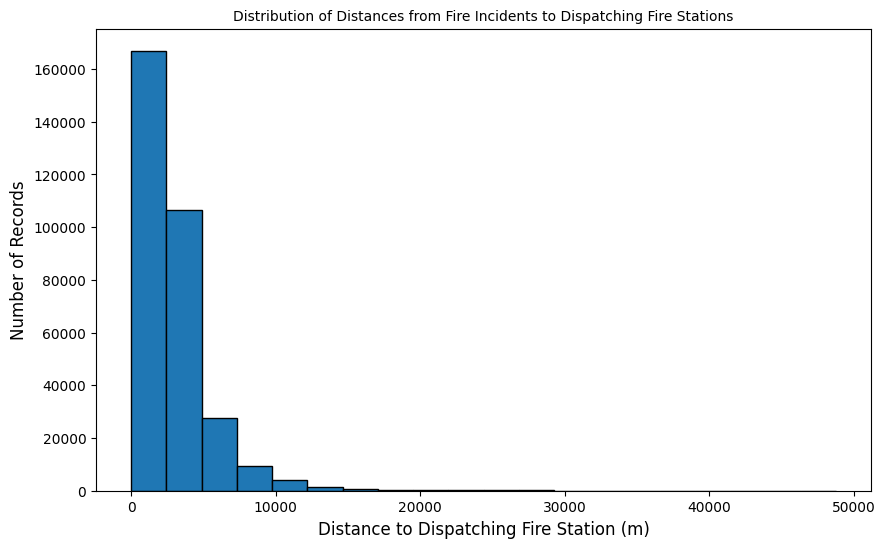

In [12]:
### Visualise the distance from incidents to the fire stations to decide the value of distance to choose
plt.figure(figsize=(10, 6))
plt.hist(distance, bins=20, edgecolor='black')

plt.title('Distribution of Distances from Fire Incidents to Dispatching Fire Stations', fontsize=10)
plt.xlabel('Distance to Dispatching Fire Station (m)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)

plt.show()

In [81]:
percentile = (mobilisation_station['distance'] <= 10000).mean() * 100
percentile

97.94166502861019

In [82]:
# create a buffer with a specific distance for each grid
distance_max = 10000

buffer_gdf = grid_gdf.copy()

buffer_gdf['buffer'] = buffer_gdf['centroid'].buffer(distance_max)
buffer_gdf = gpd.GeoDataFrame(buffer_gdf, geometry='buffer', crs = grid_gdf.crs)
buffer_gdf

,grid_id,geometry,centroid,buffer
0,0_51,"POLYGON ((386500.000 297500.000, 386500.000 29...",POINT (386250.000 297750.000),"POLYGON ((396250.000 297750.000, 396201.847 29..."
1,0_52,"POLYGON ((386500.000 298000.000, 386500.000 29...",POINT (386250.000 298250.000),"POLYGON ((396250.000 298250.000, 396201.847 29..."
2,0_53,"POLYGON ((386500.000 298500.000, 386500.000 29...",POINT (386250.000 298750.000),"POLYGON ((396250.000 298750.000, 396201.847 29..."
3,1_51,"POLYGON ((387000.000 297500.000, 387000.000 29...",POINT (386750.000 297750.000),"POLYGON ((396750.000 297750.000, 396701.847 29..."
4,1_52,"POLYGON ((387000.000 298000.000, 387000.000 29...",POINT (386750.000 298250.000),"POLYGON ((396750.000 298250.000, 396701.847 29..."
...,...,...,...,...
3729,105_18,"POLYGON ((439000.000 281000.000, 439000.000 28...",POINT (438750.000 281250.000),"POLYGON ((448750.000 281250.000, 448701.847 28..."
3730,105_19,"POLYGON ((439000.000 281500.000, 439000.000 28...",POINT (438750.000 281750.000),"POLYGON ((448750.000 281750.000, 448701.847 28..."
3731,105_20,"POLYGON ((439000.000 282000.000, 439000.000 28...",POINT (438750.000 282250.000),"POLYGON ((448750.000 282250.000, 448701.847 28..."
3732,106_18,"POLYGON ((439500.000 281000.000, 439500.000 28...",POINT (439250.000 281250.000),"POLYGON ((449250.000 281250.000, 449201.847 28..."


In [83]:
station_num_f = gpd.sjoin(station_gdf, buffer_gdf, how = 'right', op = 'within')
station_num_f['count'] = station_num_f['Station name'].notna().astype(int)

station_num_f = station_num_f.groupby('grid_id')['count'].sum().reset_index(name = 'station_count')
station_num_f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,grid_id,station_count
0,0_51,5
1,0_52,5
2,0_53,5
3,100_10,4
4,100_11,4
...,...,...
3729,9_59,6
3730,9_60,6
3731,9_61,6
3732,9_62,6


### 3. Aggregate all features

In [84]:
features = [poi_group, buildings_f, rent_f, pop_f, IMD_f, streetnet_density_f,
            street_con_f, road_density_f, distance_f, fire_neighbour_f, station_num_f]

# start with the first DataFrame
features_all = features[0]

# merge each subsequent DataFrame
for df in features[1:]:
    features_all = pd.merge(features_all, df, on='grid_id', how='outer')

features_all

,grid_id,"Accommodation, eating and drinking",Attractions,Commercial services,Education and health,Manufacturing and production,Public infrastructure,Retail,Sport and entertainment,Transport,...,total_rent,below_14,above_65,IMD,node_count,connectivity,road_length,nearest_station_distance,neighbour_frequency_per_month,station_count
0,0_51,0,0,0,0,0,0,0,0,0,...,2.756538,4.295945,9.609793,7.712966,0,1.681265,353.287313,3187.918600,0.177778,5
1,0_52,0,0,0,1,0,1,0,1,0,...,5.180923,13.806764,39.551589,7.553945,7,1.571429,1328.092389,2841.271722,0.194444,5
2,0_53,0,1,0,1,1,1,0,0,7,...,5.540563,19.354585,42.606956,7.482997,1,3.000000,768.983971,2546.139234,0.188889,5
3,100_10,0,2,1,2,0,4,0,2,2,...,170.721062,162.762178,53.084068,34.376330,11,1.545455,734.304719,1571.100570,5.922222,4
4,100_11,0,1,3,0,0,1,0,1,7,...,78.999124,268.149714,95.126309,37.460063,20,1.800000,2987.218972,1130.202194,3.855556,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,9_59,0,0,2,1,1,1,1,0,0,...,92.974819,164.247755,131.024999,25.544097,11,1.818182,2006.875970,2561.426360,1.627778,6
3730,9_60,0,0,13,2,2,3,2,1,4,...,160.313891,268.994018,177.161715,33.591975,21,1.619048,2732.349447,2808.541436,2.211111,6
3731,9_61,0,1,1,1,0,5,0,1,1,...,141.396878,197.549486,108.006668,29.080009,8,2.000000,1543.196315,3116.874236,2.677778,6
3732,9_62,3,1,4,0,0,5,1,3,5,...,75.967424,168.993990,171.377539,22.113672,20,1.550000,2025.332899,3470.144810,2.005556,6


In [85]:
dataset = pd.merge(metrics, features_all, on='grid_id', how='right')
dataset

,grid_id,median,percentile_90,"Accommodation, eating and drinking",Attractions,Commercial services,Education and health,Manufacturing and production,Public infrastructure,Retail,...,total_rent,below_14,above_65,IMD,node_count,connectivity,road_length,nearest_station_distance,neighbour_frequency_per_month,station_count
0,0_51,399.0,399.0,0,0,0,0,0,0,0,...,2.756538,4.295945,9.609793,7.712966,0,1.681265,353.287313,3187.918600,0.177778,5
1,0_52,444.0,622.6,0,0,0,1,0,1,0,...,5.180923,13.806764,39.551589,7.553945,7,1.571429,1328.092389,2841.271722,0.194444,5
2,0_53,437.5,520.9,0,1,0,1,1,1,0,...,5.540563,19.354585,42.606956,7.482997,1,3.000000,768.983971,2546.139234,0.188889,5
3,100_10,391.0,575.0,0,2,1,2,0,4,0,...,170.721062,162.762178,53.084068,34.376330,11,1.545455,734.304719,1571.100570,5.922222,4
4,100_11,294.0,526.8,0,1,3,0,0,1,0,...,78.999124,268.149714,95.126309,37.460063,20,1.800000,2987.218972,1130.202194,3.855556,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,9_59,419.0,657.0,0,0,2,1,1,1,1,...,92.974819,164.247755,131.024999,25.544097,11,1.818182,2006.875970,2561.426360,1.627778,6
3730,9_60,387.5,531.7,0,0,13,2,2,3,2,...,160.313891,268.994018,177.161715,33.591975,21,1.619048,2732.349447,2808.541436,2.211111,6
3731,9_61,405.0,525.8,0,1,1,1,0,5,0,...,141.396878,197.549486,108.006668,29.080009,8,2.000000,1543.196315,3116.874236,2.677778,6
3732,9_62,403.0,507.4,3,1,4,0,0,5,1,...,75.967424,168.993990,171.377539,22.113672,20,1.550000,2025.332899,3470.144810,2.005556,6


In [86]:
### Save the final dataset
output_file_path = 'Data/dataset_no_land.csv'
dataset.to_csv(output_file_path, index=False, encoding='utf-8')